# Topic modeling on reddit comments

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import os
import glob
import pickle
from operator import itemgetter
from datetime import datetime
from matplotlib.pyplot import cm 

In [2]:
def concat_submissions_comments(path_submissions, path_comments, filename_comments):
    all_files = glob.glob(os.path.join(path_submissions, 'part-*'))

    dfs = pd.concat([pd.read_csv(f) for f in all_files])
    dfs = dfs[dfs.num_comments != 0]

    comment_folder = glob.glob(os.path.join(path_comments, filename_comments))
    comments_files = [glob.glob(os.path.join(folder, "part-*")) for folder in comment_folder]
    comments_files_all = [file for sublist in comments_files for file in sublist]

    dfc = pd.concat([pd.read_csv(f) for f in comments_files_all])
    
    return dfs, dfc

In [3]:
def concat_comments_per_submission(x):
    return pd.Series(dict(comments=' '.join(x['body'].astype(str))))

In [4]:
import nltk
import re
import string
from gensim import corpora, models
from nltk.corpus import stopwords
from many_stop_words import get_stop_words
from collections import defaultdict

def preprocessing(text):
       #################### Pre-processing ##################
    # Removing numbers
    text = [re.sub(r'\d+', '', t) for t in text]

    # Tokenization
    tokens = [nltk.word_tokenize(doc) for doc in text]
    text_tokens = nltk.Text(tokens)

    # Stop words removal
    extra_stop = set(("''", ",",":","...",".",";","``","\'","^|","la","en","le","et","ist",
                      "das","nicht","ich","zu","du","es","von","mit","auch","let","man",
                     "für", "den", "auf", "ein", "dass", "les", "que","un","pas"))
    stops = set(stopwords.words('english')).union(extra_stop)
    #Punctuation
    stops = set(stops).union(string.punctuation)
    #French Stopwords
    stops = set(stops).union(get_stop_words('fr'))
    #German Stopwords
    stops = set(stops).union(get_stop_words('de'))
    #Italian Stopwords
    stops = set(stops).union(get_stop_words('it'))
    #Spanish Stopwords
    stops = set(stops).union(get_stop_words('es'))


    filtered_text = [[word for word in t if str(word).lower() not in stops] for t in text_tokens]

    # Remove very frequent and very in-frequent words
    lower_freq = 10
    upper_freq = 1000    
    frequency = defaultdict(int)
    for text in filtered_text:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > lower_freq and frequency[token] < upper_freq and len(token) != 1]
             for text in filtered_text]

    # Removing documents less than minimum length
    min_length = 0
    long_texts = [text for text in texts if len(text)>=min_length]
    print("No. of documents: {}".format(len(long_texts)))
    return long_texts

def topic_modeling(texts, num_topics):


    ############## Topic modeling using LDA #################
    # Dictionary of all the words
    dictionary = corpora.Dictionary(texts)

    # Vector representation of each document
    corpus = [dictionary.doc2bow(text) for text in texts]

    # At this stage, dictionary contains the list of all words, each word with an unique integer id. 
    # 'corpus' contains for each document a bag of words representation (the number of occurrences of each word).

    model = models.LdaModel(corpus, num_topics, id2word=dictionary,passes=20,chunksize=3000)
    #model.print_topics()
    ########################################################

    return model, corpus, dictionary

/Users/vidit/anaconda3/envs/python35/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Switzerland

In [6]:
path_submissions = "../data/reddit_swiss_submissions_fullcorpus"
path_comments = '../data'
filename_comments = "reddit_swiss_comments_*"

[dfs_swiss, dfc_swiss] = concat_submissions_comments(path_submissions, path_comments, filename_comments)

In [7]:
dfsc_swiss = dfs_swiss.merge(dfc_swiss, how='inner', left_on='name', right_on='link_id')
cps_swiss = dfsc_swiss.groupby(by='name_x').apply(concat_comments_per_submission)
cps_swiss = cps_swiss.reset_index()

dfs_name = pd.DataFrame(dfs_swiss[['name', 'title', 'created_utc']])
df_aggcomments_swiss = dfs_name.merge(cps_swiss, how='inner', left_on='name', right_on='name_x')
del df_aggcomments_swiss['name_x']
df_aggcomments_swiss['title_comments'] = df_aggcomments_swiss.apply(lambda x: x['title']+' '+x['comments'], axis=1)
#df_aggcomments

In [8]:
text_swiss = [t for t in df_aggcomments_swiss['title_comments']]
pickle.dump(text_swiss,open('swiss_comments.pickle','wb'))

In [9]:
text_swiss = pickle.load(open('swiss_comments.pickle','rb'))
processed_text = preprocessing(text_swiss)


No. of documents: 4825


In [10]:
num_topics = 15

[model_swiss, corpus, dictionary] = topic_modeling(processed_text, num_topics)
model_swiss.print_topics()

[(0,
  '0.023*"Swisscom" + 0.017*"data" + 0.013*"internet" + 0.010*"ms" + 0.010*"network" + 0.009*"phone" + 0.008*"news" + 0.007*"using" + 0.007*"Orange" + 0.007*"reddit"'),
 (1,
  '0.018*"price" + 0.012*"cheaper" + 0.010*"prices" + 0.010*"ticket" + 0.010*"card" + 0.009*"online" + 0.008*".-" + 0.008*"order" + 0.008*"shop" + 0.007*"buying"'),
 (2,
  '0.010*"TV" + 0.007*"Billag" + 0.007*"trains" + 0.007*"watch" + 0.006*"SBB" + 0.005*"app" + 0.004*"radio" + 0.004*"phone" + 0.004*"website" + 0.004*"show"'),
 (3,
  '0.009*"learn" + 0.009*"speaking" + 0.006*"languages" + 0.006*"french" + 0.006*"Italian" + 0.005*"canton" + 0.005*"school" + 0.005*"culture" + 0.005*"dialect" + 0.004*"english"'),
 (4,
  '0.007*"lake" + 0.006*"weather" + 0.006*"snow" + 0.006*"summer" + 0.006*"night" + 0.006*"Lausanne" + 0.006*"area" + 0.006*"near" + 0.006*"town" + 0.005*"walk"'),
 (5,
  '0.013*"beautiful" + 0.012*"trip" + 0.011*"visit" + 0.010*"Lucerne" + 0.010*"Interlaken" + 0.010*"recommend" + 0.009*"Zermatt" +

In [14]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_swiss.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_swiss['topic_number'] = most_likely_topic_per_doc



In [15]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_swiss['created_utc'].astype(int)]
df_aggcomments_swiss['dates'] = dates
month_dic = ['Jan','Feb','March','April','May','June','July','August','Sept','Oct','Nov','Dec']
# month_dic[str(df_aggcomments_swiss.dates.iloc[0].year)]
df_aggcomments_swiss['year'] = [str(df_aggcomments_swiss.dates.iloc[i].year) for i in range(len(df_aggcomments_swiss))]

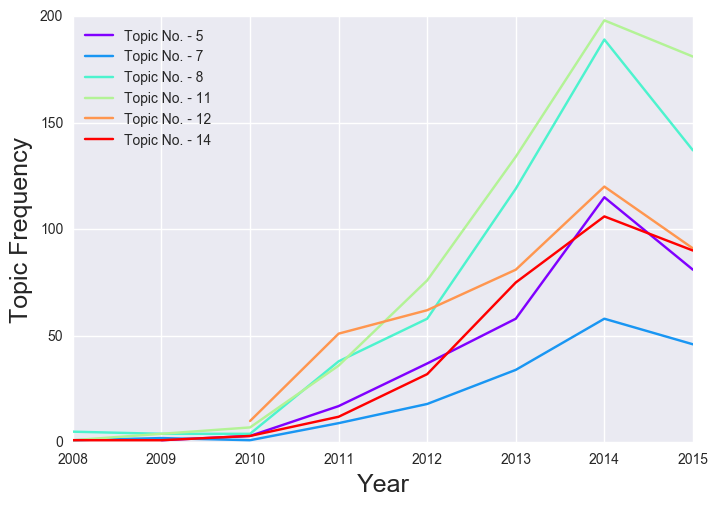

In [80]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_swiss.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,6)))

interesting_topics = [11,12,14,8,5,7]#based on coherence of word forming the topic
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)
        
        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)

## EU

In [5]:
path_submissions = "../data/reddit_europe_submissions_fullcorpus"
path_comments = '../data'
filename_comments = "reddit_europe_comments_*"

[dfs_eu, dfc_eu] = concat_submissions_comments(path_submissions, path_comments, filename_comments)

In [6]:
 
germany_subreddit_list = ['germany', 'de', 'German', 'GermanPractice', 'GermanFacts', 'GermanConversation',                  ## germany
    'SCHLAND', 'germanyusa', 'DEjobs', 'bundesliga', 'GermanyPics', 'germusic', 'de_punk', 'germanrap', 'NDH']                 ## germany
dfs_de = dfs_eu[dfs_eu['subreddit'].isin(germany_subreddit_list)]

# france_subreddit_list  = ['blagues', 'cinemacinema', 'france', 'FrancePics', 'frenchelectro', 'Frenchhistory', 'guessthefrenchmovie',      ## france
#     'Ligue1', 'Livres', 'musiquefrancaise', 'paris', 'pedale', 'philosophie', 'Politique', 'rance', 'ScienceFr', 'SocialFrance']## france
# dfs_fr = dfs_eu[dfs_eu['subreddit'].isin(france_subreddit_list)]


# italy_subreddit_list  = ['Calcio', 'ITAGLIA', 'Italianhistory', 'ITALIANMUSIC', 'italy', 'ItalyPhotos', 'Libri', 'Abruzzo', 'Apulia', 'bari',       ## italy
#     'Basilicata', 'bologna', 'Calabria', 'Campania', 'Catania', 'emilia_romagna', 'firenze', 'friuli', 'Genova', 'Italia',     ## italy
#     'lazio', 'Liguria', 'lombardia', 'Lombardy', 'marche', 'messina', 'milano', 'Modena', 'molise', 'Naples_Italy', 'napoli',  ## italy
#     'padova', 'Palermo', 'Perugia', 'Piedmont', 'piemonte', 'Pisa', 'puglia', 'roma', 'rome', 'romesocialclub', 'Sardegna',    ## italy
#     'Sardinia', 'Sicilia', 'sicily', 'Siracusa', 'torino', 'Toscana', 'trentino_alto_adige', 'trentod', 'Trieste',             ## italy
#     'tuscany', 'Umbria', 'valle_daosta', 'Veneto', 'Venezia']                                                                 ## italy
# dfs_it = dfs_eu[dfs_eu['subreddit'].isin(italy_subreddit_list)]

# spain_subreddit_list   =  ['Barcelona', 'EPANA', 'es', 'futbol', 'Granada', 'LaLiga', 'Madrid', 'spain', 'Andalucia', 'SpanishHistory']     ## spain
# dfs_es = dfs_eu[dfs_eu['subreddit'].isin(spain_subreddit_list)]

In [7]:
dfc_de = dfc_eu[dfc_eu['link_id'].isin(dfs_de['name'])]
# dfc_fr = dfc_eu[dfc_eu['link_id'].isin(dfs_fr['name'])]
# dfc_it = dfc_eu[dfc_eu['link_id'].isin(dfs_it['name'])]
# dfc_es = dfc_eu[dfc_eu['link_id'].isin(dfs_es['name'])]


In [8]:
def aggregate(dfs_c,dfc_c):
    dfsc_de = dfs_c.merge(dfc_c, how='inner', left_on='name', right_on='link_id')
    cps_de = dfsc_de.groupby(by='name_x').apply(concat_comments_per_submission)
    cps_de = cps_de.reset_index()

    dfs_name = pd.DataFrame(dfs_c[['name', 'title', 'created_utc']])
    df_aggcomments_de = dfs_name.merge(cps_de, how='inner', left_on='name', right_on='name_x')
    del df_aggcomments_de['name_x']
    df_aggcomments_de['title_comments'] = df_aggcomments_de.apply(lambda x: x['title']+' '+x['comments'], axis=1)
    return df_aggcomments_de

In [11]:
df_aggcomments_de = aggregate(dfs_de,dfc_de)
text_de = [t for t in df_aggcomments_de['title_comments']]
processed_text = preprocessing(text_de)


No. of documents: 50305


In [218]:
processes_text = pickle.load(open('processes_text_de','rb'))

In [32]:
num_topics = 45

[model_de, corpus, dictionary] = topic_modeling(processed_text, num_topics)


In [33]:
model_de.print_topics(45)

[(0,
  '0.021*"Linux" + 0.019*"application" + 0.019*"pronunciation" + 0.017*"suppose" + 0.016*"base" + 0.015*"automatically" + 0.015*"drunk" + 0.015*"thinks" + 0.014*"user" + 0.013*"Christmas"'),
 (1,
  '0.019*"additional" + 0.018*"entirely" + 0.017*"shopping" + 0.017*"enter" + 0.016*"demand" + 0.014*"visited" + 0.014*"töten" + 0.013*"United" + 0.013*"terrible" + 0.012*"posting"'),
 (2,
  '0.021*"Antifa" + 0.019*"Asyl" + 0.017*"Mist" + 0.017*"verlieren" + 0.015*"Respekt" + 0.013*"Agenda" + 0.011*"Lügenpresse" + 0.011*"Behauptungen" + 0.011*"Gender" + 0.011*"Snowden"'),
 (3,
  '0.017*"zufällig" + 0.016*"Sonntag" + 0.016*"Nacht" + 0.015*"Fußball" + 0.014*"Katze" + 0.013*"gesellschaftlichen" + 0.012*"gespielt" + 0.011*"͡°" + 0.011*"hundert" + 0.011*"privacy"'),
 (4,
  '0.017*"Get" + 0.016*"road" + 0.016*"Müll" + 0.015*"BND" + 0.012*"Vertrauen" + 0.012*"Koran" + 0.012*"wissenschaftlich" + 0.011*"trade" + 0.011*"Italy" + 0.011*"einzig"'),
 (5,
  '0.004*"result" + 0.003*"pictures" + 0.003*"W

In [34]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_de.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_de['topic_number'] = most_likely_topic_per_doc



In [35]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_de['created_utc'].astype(int)]
df_aggcomments_de['dates'] = dates
df_aggcomments_de['year'] = [str(df_aggcomments_de.dates.iloc[i].year) for i in range(len(df_aggcomments_de))]

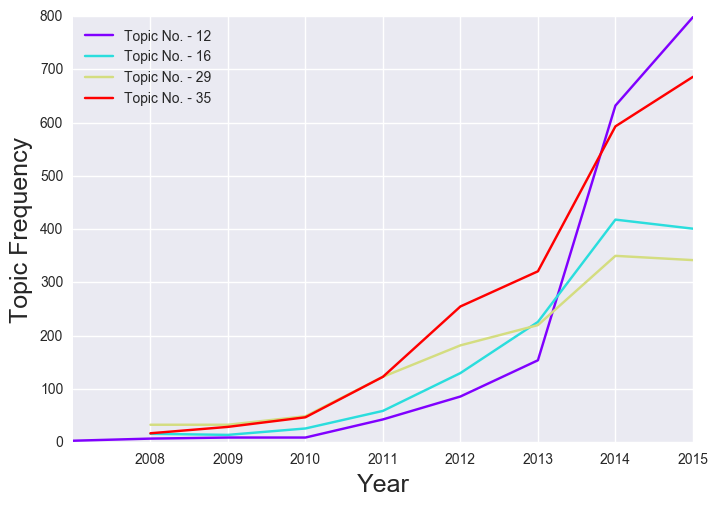

In [81]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_de.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,4)))

interesting_topics = [16,12,29,35]#based on coherence of word forming the topic
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)

        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)

In [6]:
dfs_fr = pickle.load(open('dfs_fr','rb'))
dfc_fr = pickle.load(open('dfc_fr','rb'))
df_aggcomments_fr = aggregate(dfs_fr,dfc_fr)

In [8]:
text_fr = [t for t in df_aggcomments_fr['title_comments']]
processed_text = preprocessing(text_fr)


No. of documents: 39536


In [9]:
pickle.dump(processed_text,open('processes_text_fr','wb'))

In [10]:
num_topics = 30
[model_de, corpus, dictionary] = topic_modeling(processed_text, num_topics)


In [11]:
model_de.print_topics(30)

[(0,
  '0.011*"incapable" + 0.010*"mer" + 0.007*"maladies" + 0.007*"Mélenchon" + 0.006*"J\'arrive" + 0.006*"Grecs" + 0.006*"intellectuel" + 0.006*"lâcher" + 0.005*"violer" + 0.005*"doucement"'),
 (1,
  '0.014*"match" + 0.013*"team" + 0.013*"Rennes" + 0.010*"Monaco" + 0.009*"football" + 0.008*"Ligue" + 0.008*"^bot" + 0.008*"investissement" + 0.008*"Caen" + 0.008*"play"'),
 (2,
  '0.008*"posting" + 0.007*"finding" + 0.006*"schools" + 0.006*"bank" + 0.006*"moving" + 0.005*"allow" + 0.005*"company" + 0.005*"degree" + 0.005*"following" + 0.005*"tourism"'),
 (3,
  '0.004*"recette" + 0.003*"words" + 0.003*"Americans" + 0.003*"lunettes" + 0.002*"sense" + 0.002*"hate" + 0.002*"children" + 0.002*"matter" + 0.002*"rude" + 0.002*"says"'),
 (4,
  '0.004*"soleil" + 0.004*"dormir" + 0.004*"repas" + 0.004*"midi" + 0.004*"flair" + 0.004*"sac" + 0.004*"week-end" + 0.004*"bruit" + 0.003*"verre" + 0.003*"chien"'),
 (5,
  '0.004*"maladie" + 0.003*"vol" + 0.003*"drogue" + 0.003*"avion" + 0.003*"cannabis" + 

In [12]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_de.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_fr['topic_number'] = most_likely_topic_per_doc



In [13]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_fr['created_utc'].astype(int)]
df_aggcomments_fr['dates'] = dates
df_aggcomments_fr['year'] = [str(df_aggcomments_fr.dates.iloc[i].year) for i in range(len(df_aggcomments_fr))]

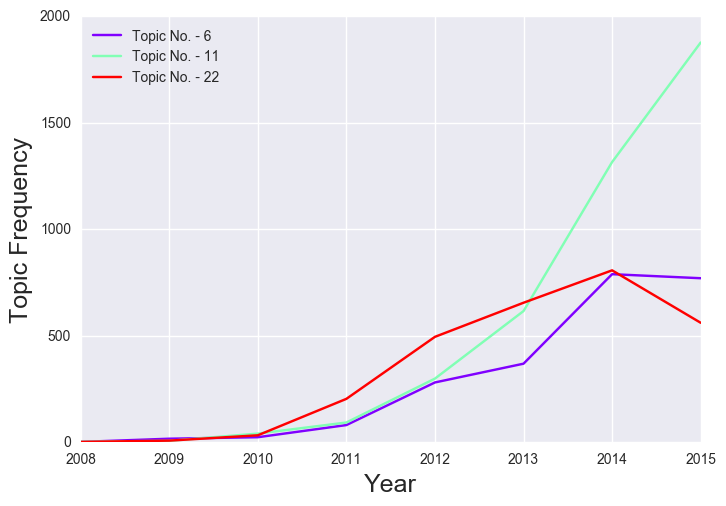

In [36]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_fr.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,3)))

interesting_topics = [11,22,6]#based on coherence of word forming the topic
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)

        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)

In [139]:
dfs_it = pickle.load(open('dfs_it','rb'))
dfc_it = pickle.load(open('dfc_it','rb'))
df_aggcomments_it = aggregate(dfs_it,dfc_it)

In [140]:
text_it = [t for t in df_aggcomments_it['title_comments']]
processed_text = preprocessing(text_it)


No. of documents: 28033


In [141]:
pickle.dump(processed_text,open('processes_text_it','wb'))

In [147]:
num_topics = 40
[model_it, corpus, dictionary] = topic_modeling(processed_text, num_topics)


In [148]:
model_it.print_topics(40)

[(0,
  '0.003*"illegale" + 0.003*"controlli" + 0.002*"norma" + 0.002*"dieta" + 0.002*"denuncia" + 0.002*"privati" + 0.002*"rischi" + 0.002*"proprietà" + 0.002*"cliente" + 0.002*"permettere"'),
 (1,
  '0.010*"latte" + 0.010*"piatto" + 0.010*"ristorante" + 0.010*"mangia" + 0.009*"pesce" + 0.008*"mangio" + 0.008*"mangiato" + 0.007*"pane" + 0.007*"piatti" + 0.007*"ricetta"'),
 (2,
  '0.022*"racist" + 0.018*"score" + 0.015*"favorite" + 0.014*"water" + 0.013*"month" + 0.011*"age" + 0.010*"camps" + 0.010*"Fun" + 0.008*"facts" + 0.008*"words"'),
 (3,
  '0.047*"performed" + 0.013*"game" + 0.011*"team" + 0.010*"removed" + 0.010*"play" + 0.009*"younger" + 0.009*"games" + 0.009*"song" + 0.009*"rush" + 0.008*"watch"'),
 (4,
  '0.014*"gender" + 0.011*"New" + 0.008*"meat" + 0.007*"oil" + 0.007*"sauce" + 0.007*"York" + 0.007*"coffee" + 0.007*"cheese" + 0.007*"dish" + 0.006*"Civati"'),
 (5,
  '0.003*"capelli" + 0.003*"coppia" + 0.002*"tedesco" + 0.002*"imparato" + 0.002*"colore" + 0.002*"coppie" + 0.00

In [149]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_it.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_it['topic_number'] = most_likely_topic_per_doc



In [150]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_it['created_utc'].astype(int)]
df_aggcomments_it['dates'] = dates
df_aggcomments_it['year'] = [str(df_aggcomments_it.dates.iloc[i].year) for i in range(len(df_aggcomments_it))]

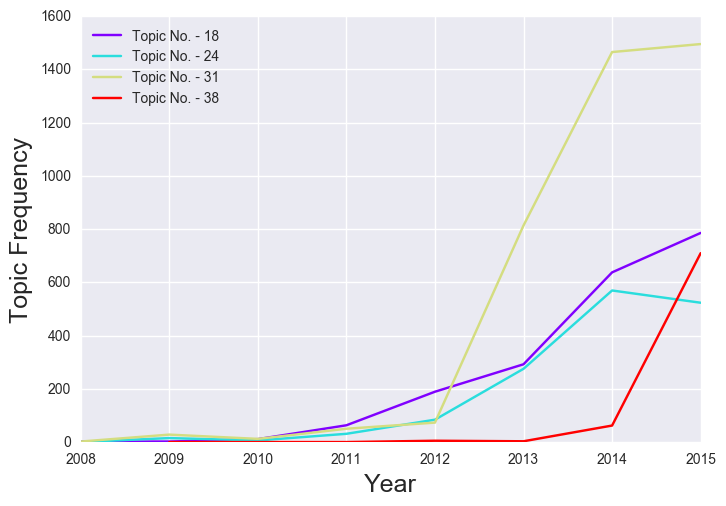

In [185]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_it.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,4)))

interesting_topics = [38,24,18,31]#based on coherence of word forming the topic
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)

        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)

In [186]:
dfs_es = pickle.load(open('dfs_es','rb'))
dfc_es = pickle.load(open('dfc_es','rb'))
df_aggcomments_es = aggregate(dfs_es,dfc_es)

In [187]:
text_es = [t for t in df_aggcomments_es['title_comments']]
processed_text = preprocessing(text_es)


No. of documents: 15241


In [189]:
num_topics = 35
[model_es, corpus, dictionary] = topic_modeling(processed_text, num_topics)


In [190]:
model_es.print_topics(35)

[(0,
  '0.068*"Movistar" + 0.058*"NIE" + 0.052*"fibre" + 0.047*"landlord" + 0.028*"Ono" + 0.026*"available" + 0.022*"installed" + 0.019*"Issues" + 0.019*"ONO" + 0.018*"Callao"'),
 (1,
  '0.014*"PP" + 0.009*"noticia" + 0.009*"años" + 0.008*"dinero" + 0.008*"parece" + 0.007*"hecho" + 0.007*"gobierno" + 0.007*"españoles" + 0.006*"partido" + 0.006*"ley"'),
 (2,
  '0.017*"Plaza" + 0.013*"tapas" + 0.012*"plaza" + 0.011*"restaurant" + 0.010*"park" + 0.010*"eat" + 0.009*"restaurants" + 0.008*"madrid" + 0.007*"line" + 0.007*"theres"'),
 (3,
  '0.014*"San" + 0.012*"Seville" + 0.010*"beaches" + 0.009*"Oviedo" + 0.008*"Alhambra" + 0.007*"spend" + 0.007*"festival" + 0.007*"coast" + 0.007*"Toledo" + 0.006*"north"'),
 (4,
  '0.009*"visa" + 0.009*"number" + 0.007*"passport" + 0.006*"bank" + 0.006*"company" + 0.006*"process" + 0.006*"working" + 0.005*"legal" + 0.005*"paid" + 0.005*"apply"'),
 (5,
  '0.008*"shops" + 0.007*"shop" + 0.006*"stores" + 0.005*"drink" + 0.005*"store" + 0.005*"fans" + 0.005*"se

In [191]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_es.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_es['topic_number'] = most_likely_topic_per_doc



In [192]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_es['created_utc'].astype(int)]
df_aggcomments_es['dates'] = dates
df_aggcomments_es['year'] = [str(df_aggcomments_es.dates.iloc[i].year) for i in range(len(df_aggcomments_es))]

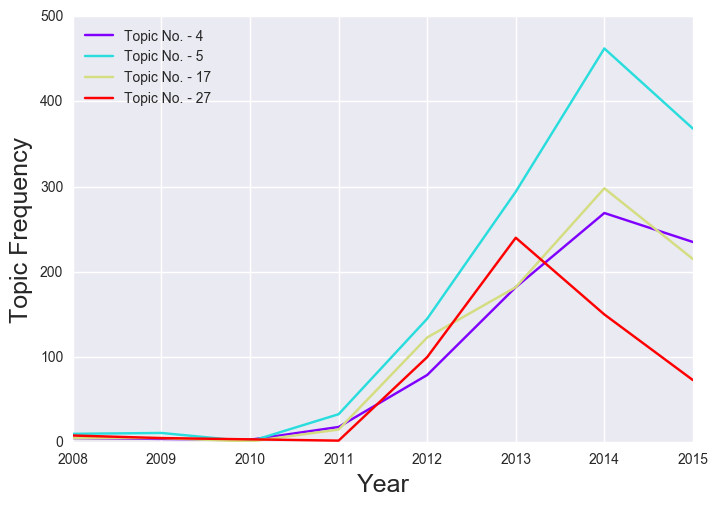

In [217]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_es.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,4)))

interesting_topics = [4,5,17,27]#based on coherence of word forming the topic
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)

        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)